In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2016'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2016'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2016/apr16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/aug16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/dec16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/feb16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/jan16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/jul16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/jun16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/mar16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/may16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/nov16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/oct16.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2016/sep16.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 23.9 s, sys: 45.7 ms, total: 24 s
Wall time: 35.6 s


In [8]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122693 entries, 0 to 122692
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          122693 non-null  datetime64[ns]
 1   hour          122693 non-null  int64         
 2   offense_type  122693 non-null  object        
 3   beat          122693 non-null  object        
 4   premise       121293 non-null  object        
 5   blockrange    122693 non-null  object        
 6   streetname    122693 non-null  object        
 7   type          122693 non-null  object        
 8   suffix        122693 non-null  object        
 9   ._offenses    122693 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 9.4+ MB


In [10]:
df.head()

,date,hour,offense_type,beat,premise,blockrange,streetname,type,suffix,._offenses
0,2016-04-10,20,Robbery,10H10,"Road, Street, or Sidewalk",4000-4099,MILBY,-,-,1
1,2016-04-11,19,Aggravated Assault,10H10,"Road, Street, or Sidewalk",400-499,YORK,-,-,2
2,2016-04-12,20,Robbery,10H10,Apartment,1900-1999,RUNNELS,-,-,1
3,2016-04-13,2,Auto Theft,10H10,Driveway,100-199,SIDNEY,-,-,1
4,2016-04-14,3,Burglary,10H10,Service or Gas Station,3300-3399,CANAL,ST,-,1


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

date               0
hour               0
offense_type       0
beat               0
premise         1400
blockrange         0
streetname         0
type               0
suffix             0
._offenses         0
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
premise,1.14
date,0.00
hour,0.00
offense_type,0.00
beat,0.00
blockrange,0.00
streetname,0.00
type,0.00
suffix,0.00
._offenses,0.00


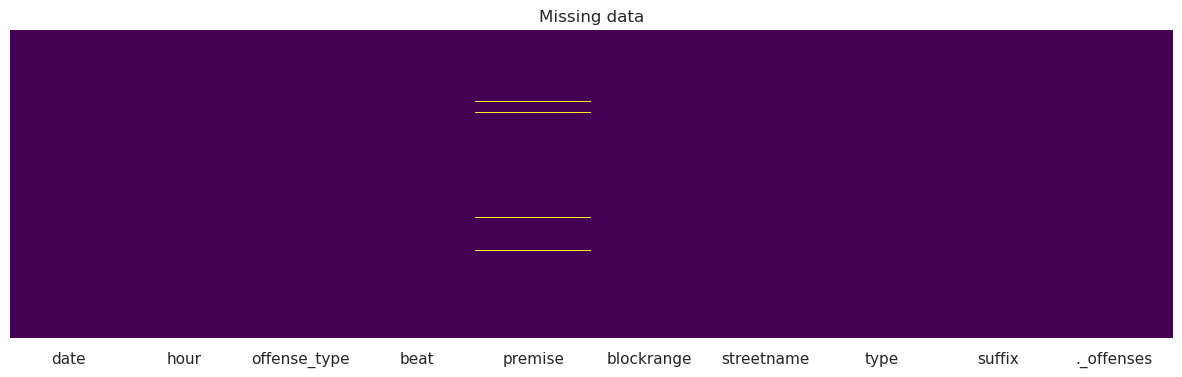

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Fix column names

In [14]:
#change column name

df.rename(columns={
    '._offenses': 'offenses',
}, inplace=True)

df.rename(columns={'blockrange': 'block_range', 'streetname': 'street_name'}, inplace=True)

## Fix null values

In [15]:
df[df.premise.isna()]

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses
176,2016-04-23,19,Theft,10H40,NaN,1000-1099,ELGIN,ST,-,1
309,2016-04-02,9,Theft,10H60,NaN,5900-5999,SCOTT,ST,-,1
326,2016-04-27,5,Burglary,10H60,NaN,2300-2399,WICHITA,ST,-,1
485,2016-04-10,10,Theft,10H80,NaN,1100-1199,AUTREY,ST,-,1
670,2016-04-26,15,Aggravated Assault,11H10,NaN,7400-7499,SATSUMA,-,-,1
...,...,...,...,...,...,...,...,...,...,...
121999,2016-09-13,0,Theft,7C50,NaN,15700-15799,JOHN F KENNEDY,BLVD,-,2
122013,2016-09-14,0,Theft,7C50,NaN,15200-15299,JOHN F KENNEDY,BLVD,-,1
122184,2016-09-15,23,Theft,8C30,NaN,9100-9199,WAYSIDE,-,N,1
122218,2016-09-01,7,Theft,8C40,NaN,9000-9099,SPIKEWOOD,DR,-,1


In [16]:
## Change null values to UNK

df["premise"].fillna("UNK", inplace = True)

In [17]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

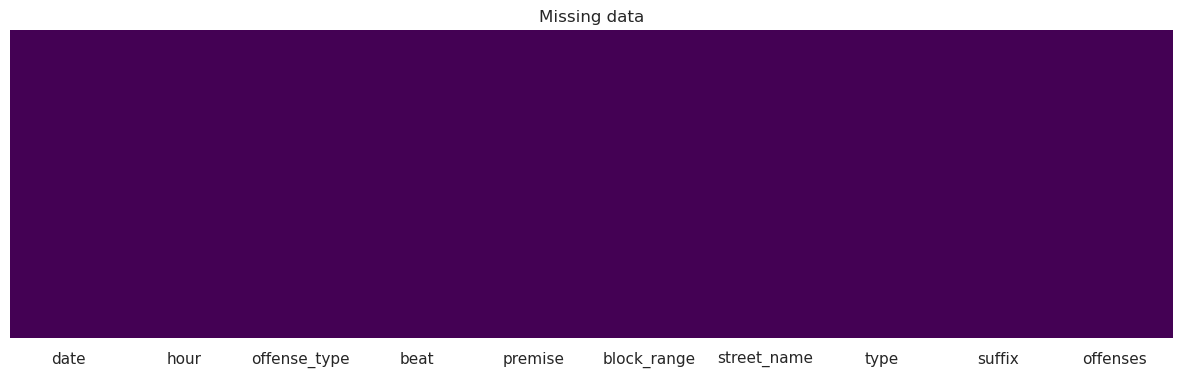

In [18]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [19]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122693 entries, 0 to 122692
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  122693 non-null  object        
 1   beat          122693 non-null  object        
 2   premise       122693 non-null  object        
 3   block_range   122693 non-null  object        
 4   street_name   122693 non-null  object        
 5   type          122693 non-null  object        
 6   suffix        122693 non-null  object        
 7   offenses      122693 non-null  int64         
 8   date_time     122693 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.4+ MB


In [21]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Robbery,10H10,"Road, Street, or Sidewalk",4000-4099,MILBY,-,-,1,2016-04-10 20:00:00
1,Aggravated Assault,10H10,"Road, Street, or Sidewalk",400-499,YORK,-,-,2,2016-04-11 19:00:00
2,Robbery,10H10,Apartment,1900-1999,RUNNELS,-,-,1,2016-04-12 20:00:00
3,Auto Theft,10H10,Driveway,100-199,SIDNEY,-,-,1,2016-04-13 02:00:00
4,Burglary,10H10,Service or Gas Station,3300-3399,CANAL,ST,-,1,2016-04-14 03:00:00


## Convert offenses to integer

In [22]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122693 entries, 0 to 122692
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  122693 non-null  object        
 1   beat          122693 non-null  object        
 2   premise       122693 non-null  object        
 3   block_range   122693 non-null  object        
 4   street_name   122693 non-null  object        
 5   type          122693 non-null  object        
 6   suffix        122693 non-null  object        
 7   offenses      122693 non-null  int64         
 8   date_time     122693 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.4+ MB


# Create year column

In [24]:
df['year'] = 2016
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time,year
0,Robbery,10H10,"Road, Street, or Sidewalk",4000-4099,MILBY,-,-,1,2016-04-10 20:00:00,2016
1,Aggravated Assault,10H10,"Road, Street, or Sidewalk",400-499,YORK,-,-,2,2016-04-11 19:00:00,2016
2,Robbery,10H10,Apartment,1900-1999,RUNNELS,-,-,1,2016-04-12 20:00:00,2016
3,Auto Theft,10H10,Driveway,100-199,SIDNEY,-,-,1,2016-04-13 02:00:00,2016
4,Burglary,10H10,Service or Gas Station,3300-3399,CANAL,ST,-,1,2016-04-14 03:00:00,2016


## change order of columns

In [25]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2016-04-10 20:00:00,1,Robbery,4000-4099,MILBY,-,-,10H10,"Road, Street, or Sidewalk",2016
1,2016-04-11 19:00:00,2,Aggravated Assault,400-499,YORK,-,-,10H10,"Road, Street, or Sidewalk",2016
2,2016-04-12 20:00:00,1,Robbery,1900-1999,RUNNELS,-,-,10H10,Apartment,2016
3,2016-04-13 02:00:00,1,Auto Theft,100-199,SIDNEY,-,-,10H10,Driveway,2016
4,2016-04-14 03:00:00,1,Burglary,3300-3399,CANAL,ST,-,10H10,Service or Gas Station,2016


## Save to bucket

In [26]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2016.csv'

In [27]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 837 ms, sys: 112 ms, total: 949 ms
Wall time: 16.7 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2016.csv'],
 'partitions_values': {}}

# Save Sample

In [28]:
%%time
sample_100 = df.sample(100)


bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 24.5 ms, sys: 57 µs, total: 24.5 ms
Wall time: 379 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2016.csv'],
 'partitions_values': {}}